In [1]:
import os 
from pathlib import Path
from dotenv import load_dotenv
import pickle
import pandas as pd
import torch
from tqdm import tqdm
import seaborn as sns

/home/edoardo/GitProjects/rl_wolpertinger/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
base_path = Path.home()/Path(os.environ.get("SAVE_PATH"))

In [4]:
# loading slateq results
ALPHA = 0.25
SEEDS = [33, 42, 5, 7, 97]

In [5]:
def parse_data(data_dict: dict, alg_nam:str, seed: int)->pd.DataFrame:
    # convert from torch to float
    for k, v in data_dict.items():
        if isinstance(v, torch.Tensor):
            data_dict[k] = v.item()
        elif isinstance(v, list):
            if isinstance(v[0], torch.Tensor):
                data_dict[k] = [x.item() for x in v]
    data_df = pd.DataFrame(data_dict)
    data_df["alg_name"] = alg_nam
    data_df["seed"] = seed
    data_df = data_df.reset_index().rename(columns={"index": "episode"})
    return data_df

In [6]:
# load slateq results
res_df_list = []
for seed in tqdm(SEEDS):
    slateq_dict = pickle.load(open(base_path / Path(f"observed_topic_slateq_{ALPHA}_{seed}")/ "logs_dict.pickle", "rb"))
    res_df = parse_data(slateq_dict, "SlateQ", seed)
    res_df_list.append(res_df)
# concat all results
final_df = pd.concat(res_df_list)

100%|██████████| 5/5 [00:36<00:00,  7.24s/it]


In [46]:
# load wp results
res_df_list = []
for seed in tqdm(SEEDS):
    for knearest in [5, 10, 20]:
        slateq_dict = pickle.load(open(base_path / Path(f"observed_topic_wa_{knearest}_slateq_{ALPHA}_{seed}")/ "logs_dict.pickle", "rb"))
        res_df = parse_data(slateq_dict, f"Slate-Wolpertinger {knearest}%", seed)
        res_df_list.append(res_df)
# concat all results
wp_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, wp_df])

100%|██████████| 5/5 [02:04<00:00, 24.84s/it]


In [ ]:
# load wp results
res_df_list = []
for seed in tqdm(SEEDS):
    for knearest in [5, 10, 20]:
        slateq_dict = pickle.load(open(base_path / Path(f"observed_topic_wa_{knearest}_slateq_{ALPHA}_{seed}")/ "logs_dict.pickle", "rb"))
        res_df = parse_data(slateq_dict, f"Slate-Wolpertinger {knearest}%", seed)
        res_df_list.append(res_df)
# concat all results
wp_df = pd.concat(res_df_list)
final_df = pd.concat([final_df, wp_df])

In [53]:
final_df = final_df.reset_index(drop=True)

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the plot style to "ticks"
sns.set_style("whitegrid", {"grid.linestyle": "--", "axes.edgecolor": "gray"})

# Set the font size and line width for the plot
# sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.5})

m = 100
n = 20

# apply rolling mean on ep_cum_satisfaction
final_df["ep_cum_satisfaction_rm"] = final_df.groupby("alg_name")["ep_cum_satisfaction"].transform(lambda x: x.rolling(m, 1).mean())
# apply rolling mean on ep_cum_satisfaction
final_df["ep_avg_reward_rm"] = final_df.groupby("alg_name")["ep_avg_reward"].transform(lambda x: x.rolling(m, 1).mean())
# apply rolling mean on ep_cum_satisfaction
final_df["loss_rm"] = final_df.groupby("alg_name")["loss"].transform(lambda x: x.rolling(m, 1).mean())

# Create a new DataFrame that only contains every n-th row of the original DataFrame
new_df = final_df[final_df['episode'] % n == 0]

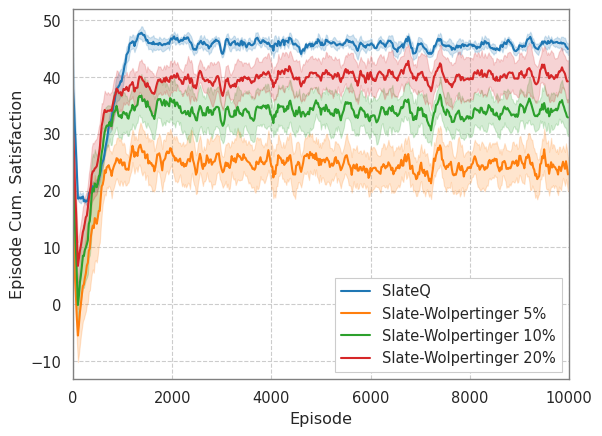

In [80]:
# Plot the mean of ep_cum_satisfaction across different seeds for each alg_name
sns.lineplot(x="episode", y="ep_cum_satisfaction_rm", hue="alg_name", errorbar="se", data=new_df)

legend = plt.legend(title='', fancybox=False)
legend.get_frame().set_alpha(None)

# Add a title and axes labels
plt.xlim(0, 10000)
plt.xlabel("Episode")
plt.ylabel("Episode Cum. Satisfaction")
plt.show()


In [81]:
new_df.keys()

Index(['episode', 'session_length', 'ep_cum_satisfaction',
       'ep_avg_satisfaction', 'loss', 'best_rl_avg_diff', 'best_avg_avg_diff',
       'cum_normalized', 'alg_name', 'seed', 'ep_cum_satisfaction_rm',
       'ep_cum_reward', 'ep_avg_reward', 'actor_loss', 'ep_avg_reward_rm',
       'loss_rm'],
      dtype='object')

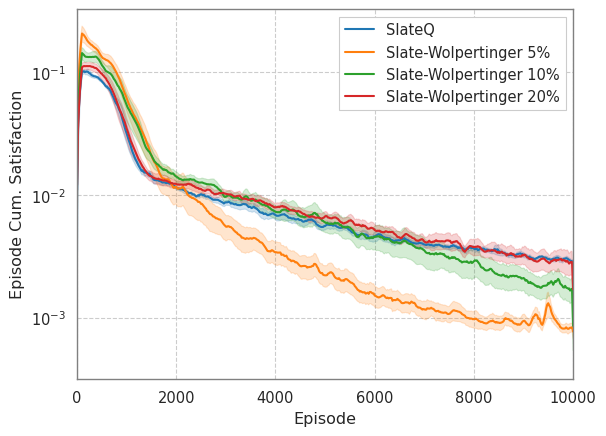

In [84]:
# Plot the mean of ep_cum_satisfaction across different seeds for each alg_name
sns.lineplot(x="episode", y="loss_rm", hue="alg_name", errorbar="se", data=new_df)

legend = plt.legend(title='', fancybox=False)
legend.get_frame().set_alpha(None)

# Add a title and axes labels
plt.xlim(0, 10000)
plt.xlabel("Episode")
plt.ylabel("Episode Cum. Satisfaction")
plt.yscale("log")
plt.show()